In [39]:
%%capture --no-stderr
%pip install -U langgraph langchain_community

In [40]:
!pip install -U langchain
!pip install -qU langchain-groq

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

# os.environ["OPENAI_API_KEY"]
# os.environ["LANGCHAIN_API_KEY"]
# os.environ["GROQ_API_KEY"]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "llama-agent"

In [135]:
import json
import pandas as pd
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from typing import Annotated, Literal
import tempfile
import os
import re

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import AnyMessage, add_messages

# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    raw_csv_path: str
    orange_csv_path: str
    green_csv_path: str
    column_description_path: str
    plot_output_path: str

# Define a new graph
workflow = StateGraph(State)

# Add a node for loading the files
def load_files(state: State) -> dict:
    raw_csv_path = state["raw_csv_path"]
    orange_csv_path = state["orange_csv_path"]
    green_csv_path = state["green_csv_path"]
    column_description_path = state["column_description_path"]
    plot_output_path = raw_csv_path.replace("query_result.csv", "stakes_vs_rewards_plot.png")
    
    try:
        raw_df = pd.read_csv(raw_csv_path)
        orange_df = pd.read_csv(orange_csv_path)
        green_df = pd.read_csv(green_csv_path)

        with open(column_description_path, "r", encoding="utf-8") as f:
            column_description = f.read()

    except Exception as e:
        return {"messages": [AIMessage(content=f"Error loading files: {str(e)}")]}
    
    return {
        "messages": [AIMessage(content=f"Loaded files successfully."), AIMessage(content=f"Plot will be saved at {plot_output_path}"), AIMessage(content=f"Column descriptions:\n{column_description}")],
        "raw_df": raw_df,
        "orange_df": orange_df,
        "green_df": green_df,
        "column_description": column_description,
        "plot_output_path": plot_output_path,
        "orange_csv_path": orange_csv_path,
        "green_csv_path": green_csv_path
    }

workflow.add_node("load_files", load_files)

# Add a node for generating the Python script for plotting
def generate_plot_script(state: State) -> dict[str, list[AIMessage]]:
    raw_csv_path = state["raw_csv_path"]
    orange_csv_path = state["orange_csv_path"]
    green_csv_path = state["green_csv_path"]
    plot_output_path = state["plot_output_path"]
    column_description_path = state["column_description_path"]

    plot_script_prompt = f"""
        You are an AI assistant that generates a Python script for data visualization. 
        Ensure:
        - It reads three CSV files:
            1. The raw data file at "{raw_csv_path}".
            2. The processed median data CSV file at "{orange_csv_path}".
            3. The processed linear regression data CSV file at "{green_csv_path}".
        - It creates a plot with:
            1. Data from the columns 'total_stakes' and 'total_rewards' from raw data, creating blue scatter points, with size=1, alpha=0.3, color='blue', labeled 'Raw Data'.
            2. Orange scatter points for binned medians data. Scatter plot from the orange CSV, using 10**df_median['log_stakes'], 10**df_median['log_rewards'], labeled 'Median per bin'.
            3. A green line for the linear regression ('predicted_rewards' from the green CSV), color='green', labeled 'Linear Regression'.
        - Use logarithmic scales for both x and y axes, for example, plt.xscale('log').
        - For total_stakes and log_stakes scatter points and the linear regression line (total_stakes), only plot the data >= 10**13. Filter out the data < 10**13.
        - Only executable Python code is returned, with no explanations or comments.
        - The script reads three CSV files.
        - The script uses pandas for data loading, matplotlib.pyplot for plotting, and numpy for numerical operations.
        - The plot is saved to "{plot_output_path}" and displayed.
    """
#        - Only keep data points whose total stakes are larger than 1e13.
#        - For the orange data points, only keep data points whose median reward is larger than 1e13.
    
    chat_model = ChatGroq(model_name="llama3-70b-8192", temperature=0.0)
    response = chat_model.invoke(plot_script_prompt)
    script_code = response.content.strip()
    
    # Extract only the Python code using regex
    match = re.search(r'```python\n(.*?)```', script_code, re.DOTALL)
    script_code = match.group(1).strip() if match else script_code
    
    # Remove markdown artifacts and leading non-Python text
    script_code = re.sub(r'^[^\n]*?\n', '', script_code, 1).strip()
    script_code = script_code.replace("```", "").strip()
    
    if not script_code:
        return {"messages": [AIMessage(content="Error: Plot script generation failed.")]}

    # Validate syntax before execution
    try:
        compile(script_code, '<string>', 'exec')
    except SyntaxError as e:
        return {"messages": [AIMessage(content=f"Syntax Error in generated script: {str(e)}\n\nScript:\n{script_code}")]} 

    return {
        "messages": [AIMessage(content=script_code)],
        "plot_output_path": plot_output_path
    }

workflow.add_node("generate_plot_script", generate_plot_script)

# Add a node for executing the plot script
def execute_plot_script(state: State) -> dict[str, list[AIMessage]]:
    script_code = state["messages"][-1].content
    plot_output_path = state["plot_output_path"]

    try:
        with tempfile.NamedTemporaryFile(suffix=".py", delete=False, mode="w") as temp_script:
            temp_script.write(script_code)
            temp_script_path = temp_script.name
        
        exec_globals = {
            "__file__": temp_script_path,
            "plot_output_path": plot_output_path
        }
        
        exec(open(temp_script_path).read(), exec_globals)
        os.remove(temp_script_path)  # Clean up temp file
        
        return {
            "messages": [AIMessage(content=f"Plot generated successfully and saved at {plot_output_path}.")],
            "plot_output_path": plot_output_path
        }
    except Exception as e:
        return {"messages": [AIMessage(content=f"Error executing plot script: {str(e)}\n\nScript:\n{script_code}")]}        

workflow.add_node("execute_plot_script", execute_plot_script)

# Define workflow edges
workflow.add_edge(START, "load_files")
workflow.add_edge("load_files", "generate_plot_script")
workflow.add_edge("generate_plot_script", "execute_plot_script")
workflow.add_edge("execute_plot_script", END)

# Compile workflow
app = workflow.compile()

### Visualize the graph

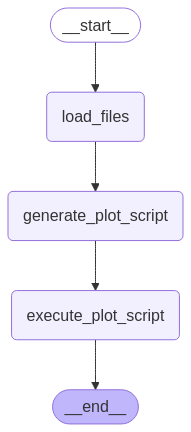

In [138]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod


display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

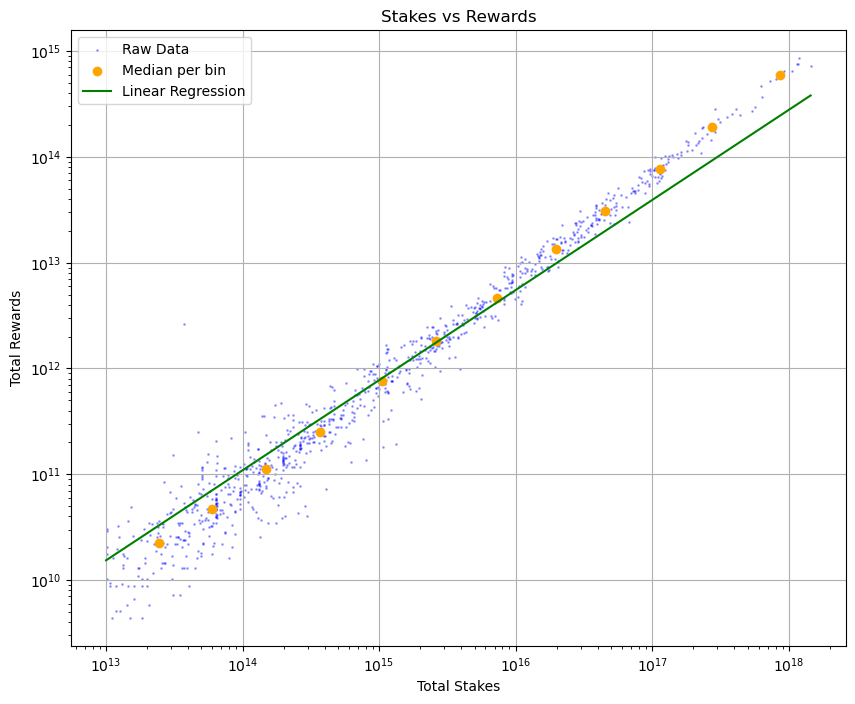

Plot generated successfully and saved at /Users/yangxiaotong/Documents/UZH/HS2024/MA Thesis/stakes_vs_rewards_plot.png.


In [ ]:
# Define input and output CSV file paths
raw_csv_path = "./query_result.csv"  
green_csv_path = "./second_graph_output_green.csv"
orange_csv_path = "./second_graph_output_orange.csv"
column_description_path = "./second_graph_output_1.txt"

user_prompt = '''
    Generate a Python script to create a log-log scatter plot with the following specifications:
    1. Import Pandas as pd
    2. Load the raw data CSV from "{raw_csv_path}" into a pandas DataFrame with columns 'total_stakes' and 'total_rewards'.
    3. Load the binned median data CSV from "{orange_csv_path}" into a pandas DataFrame with columns 'median_stakes' and 'median_rewards'.
    4. Load the linear regression data CSV from "{green_csv_path}" into a pandas DataFrame with columns 'total_stakes' and 'predicted_rewards'.
    5. Filter out rows with non-positive (≤ 0), NaN, or missing values in 'total_stakes', 'total_rewards', 'log_stakes', 'log_rewards', or 'predicted_rewards' from all DataFrames.
    6. Convert all relevant columns to numeric, coercing errors to NaN, and drop any remaining NaNs.
    IMPORTANT: 7. Create the plot.
    8. Use logarithmic scales for both x and y axes, for example, plt.xscale('log').
    9. Label the x-axis as 'Pool Stakes (ADA)' and the y-axis as 'Pool Rewards (ADA)'.
    10. Set the plot title to 'Received Stakes and Rewards by Pools across all Epochs'.
    11. Include a legend.
    12. Save the plot as a PNG file to "{plot_output_path}" and display it.
'''

# Initialize the workflow state
state = {
    "messages": [("user", user_prompt)],
    "raw_csv_path": raw_csv_path,
    "green_csv_path": green_csv_path,
    "orange_csv_path": orange_csv_path,
    "column_description_path": column_description_path,
    "plot_output_path": raw_csv_path.replace("query_result.csv", "stakes_vs_rewards_plot.png"),
    #"user_prompt": user_prompt
}

result = app.invoke(state)
print(result["messages"][-1].content)

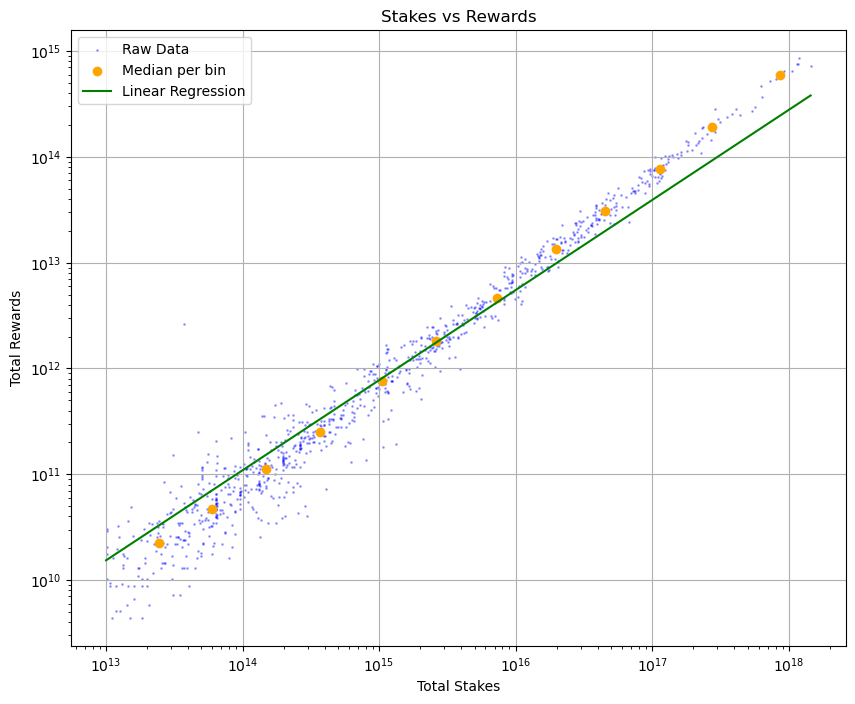

In [ ]:
# Plotting the data using the generated script

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read CSV files
df_raw = pd.read_csv('./query_result.csv')
df_median = pd.read_csv('./second_graph_output_orange.csv')
df_linear = pd.read_csv('./second_graph_output_green.csv')

# Filter data >= 10**13
df_raw = df_raw[df_raw['total_stakes'] >= 10**13]
df_median = df_median[df_median['log_stakes'] >= 13]
df_linear = df_linear[df_linear['total_stakes'] >= 10**13]

# Create plot
plt.figure(figsize=(10, 8))
plt.scatter(df_raw['total_stakes'], df_raw['total_rewards'], s=1, alpha=0.3, color='blue', label='Raw Data')
plt.scatter(10**df_median['log_stakes'], 10**df_median['log_rewards'], color='orange', label='Median per bin')
plt.plot(df_linear['total_stakes'], df_linear['predicted_rewards'], color='green', label='Linear Regression')

# Set logarithmic scales
plt.xscale('log')
plt.yscale('log')

# Set title and labels
plt.title('Stakes vs Rewards')
plt.xlabel('Total Stakes')
plt.ylabel('Total Rewards')

# Legend and grid
plt.legend()
plt.grid(True)

# Save and display plot
plt.savefig('./stakes_vs_rewards_plot.png')
plt.show()